# **Librerias**

In [2]:
!python -m spacy download es_core_news_md -q
!pip install pyspellchecker -q

2023-12-17 13:51:57.870237: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-17 13:51:57.870289: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-17 13:51:57.871577: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-17 13:51:59.434857: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 MB 15.6 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_md')
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 2

In [3]:
import json
import re
import spacy
import pandas as pd
import nltk
from nltk.corpus import stopwords
from spellchecker import SpellChecker
nltk.download('stopwords')
nlp = spacy.load("es_core_news_md")
stop_words = set(stopwords.words('spanish'))
spell = SpellChecker(language='es')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# **Funciones**

In [4]:
def minusculas(text):
    # Convertir a minúsculas
    text = text.lower()
    return text

def lematizar(texto):
     doc = nlp(texto)
     lemas = [token.lemma_ for token in doc]
     return lemas

def signos_puntuacion(text):
    # Sustituir acentos por letras sin acentos
    text = re.sub(r'[áäâà]', 'a', text)
    text = re.sub(r'[éêèë]', 'e', text)
    text = re.sub(r'[íîìï]', 'i', text)
    text = re.sub(r'[óôòö]', 'o', text)
    text = re.sub(r'[úûùü]', 'u', text)
    # Eliminar signos de puntuación
    text = re.sub(r'[^\w\s]', '', text)
    return text

def remove_stop_words(text):
    words = text.split()
    filtered_text = []
    for word in words:
        if word.lower() not in stop_words:
            filtered_text.append(word)
    return ' '.join(filtered_text)

# Función para corregir el texto
def corregir_texto(texto):
    palabras = texto.split()
    #corregido = [spell.correction(palabra) for palabra in palabras]
    corregido = [spell.correction(palabra) if spell.correction(palabra) is not None else palabra for palabra in palabras]
    texto_corregido = ' '.join(corregido)
    return texto_corregido

def create_dataframe(intents):
    dfs = []
    for intent in intents:
        for pattern, response in zip(intent['patterns'], intent['responses']):
            df = pd.DataFrame({
                'pregunta': [pattern],
                'respuesta': [response],
                'label': [intent['tag']]
            })
            dfs.append(df)
    df = pd.concat(dfs, ignore_index=True)
    return df

In [7]:
# Cargar archivo JSON con los datos de entrenamiento
with open('/content/drive/MyDrive/Colab Notebooks/transfomer/chatbot1000.json', 'r', encoding='utf-8') as f:
    data = json.load(f)
df = create_dataframe(data['intents'])

In [ ]:
df[["pregunta","respuesta","label"]].head()

,pregunta,respuesta,label
0,Hola,¡Hola! ¿En qué puedo ayudarte?,saludos
1,"Hola, ¿cómo te va?",¡Hola! Estoy aquí para responder tus preguntas.,saludos
2,Buen día,¡Buen día! ¿En qué puedo ayudarte?,saludos
3,¡Hola! ¿Qué tal estás hoy?,"Estoy bien, gracias. ¿En qué puedo ayudarte?",saludos
4,Hola ¡Saludos!,¡Saludos! ¿Qué puedo hacer por ti?,saludos


In [8]:
# Aplicar cada función y crear columnas individuales
df['pregunta_minusculas']     = df['pregunta'].apply(minusculas)
df['pregunta_sin_puntuacion'] = df['pregunta_minusculas'].apply(signos_puntuacion)
df['pregunta_corregida']      = df['pregunta_sin_puntuacion'].apply(corregir_texto)
df['pregunta_lematizada']     = df['pregunta_corregida'].apply(lambda x: ' '.join(lematizar(x)))
df['pregunta_sin_stopwords']  = df['pregunta_lematizada'].apply(remove_stop_words)
# Crear una columna final con el texto limpio
df['pregunta_limpia'] = df['pregunta_sin_stopwords']

In [9]:
df.columns

Index(['pregunta', 'respuesta', 'label', 'pregunta_minusculas',
       'pregunta_sin_puntuacion', 'pregunta_corregida', 'pregunta_lematizada',
       'pregunta_sin_stopwords', 'pregunta_limpia'],
      dtype='object')

In [10]:
colProcesadas = ['pregunta','pregunta_minusculas','pregunta_sin_puntuacion', 'pregunta_corregida', 'pregunta_lematizada','pregunta_sin_stopwords', 'pregunta_limpia']

In [11]:
df[colProcesadas].tail()

,pregunta,pregunta_minusculas,pregunta_sin_puntuacion,pregunta_corregida,pregunta_lematizada,pregunta_sin_stopwords,pregunta_limpia
925,¿Qué podemos encontrar en la superficie de Plu...,¿qué podemos encontrar en la superficie de plu...,que podemos encontrar en la superficie de pluton,que podemos encontrar en la superficie de pluto,que poder encontrar en el superficie de pluto,poder encontrar superficie pluto,poder encontrar superficie pluto
926,¿Hay montañas en la superficie de Plutón?,¿hay montañas en la superficie de plutón?,hay montañas en la superficie de pluton,hay montañas en la superficie de pluto,haber montaña en el superficie de pluto,haber montaña superficie pluto,haber montaña superficie pluto
927,¿Cómo es el terreno de Plutón?,¿cómo es el terreno de plutón?,como es el terreno de pluton,como es el terreno de pluto,como ser el terreno de pluto,ser terreno pluto,ser terreno pluto
928,¿Qué tipo de superficie tiene Plutón?,¿qué tipo de superficie tiene plutón?,que tipo de superficie tiene pluton,que tipo de superficie tiene pluto,que tipo de superficie tener pluto,tipo superficie tener pluto,tipo superficie tener pluto
929,¿Qué descubrimientos se han hecho sobre la sup...,¿qué descubrimientos se han hecho sobre la sup...,que descubrimientos se han hecho sobre la supe...,que descubrimientos se han hecho sobre la supe...,que descubrimiento él haber hacer sobre el sup...,descubrimiento haber hacer superficie pluto,descubrimiento haber hacer superficie pluto


# **Visualización de Etiquetas**

In [12]:
import pandas as pd

# Conteo de etiquetas
etiquetas = df['label'].value_counts()
conteo_etiquetas_df = pd.DataFrame({'Etiqueta': etiquetas.index, 'Frecuencia': etiquetas.values})

In [13]:
conteo_etiquetas_df

,Etiqueta,Frecuencia
0,saludos,10
1,saturno_orbita,10
2,urano_rotacion,10
3,urano_color,10
4,urano_atmosfera,10
...,...,...
88,tierra_orbita,10
89,tierra_rotacion,10
90,tierra_color,10
91,tierra_atmosfera,10


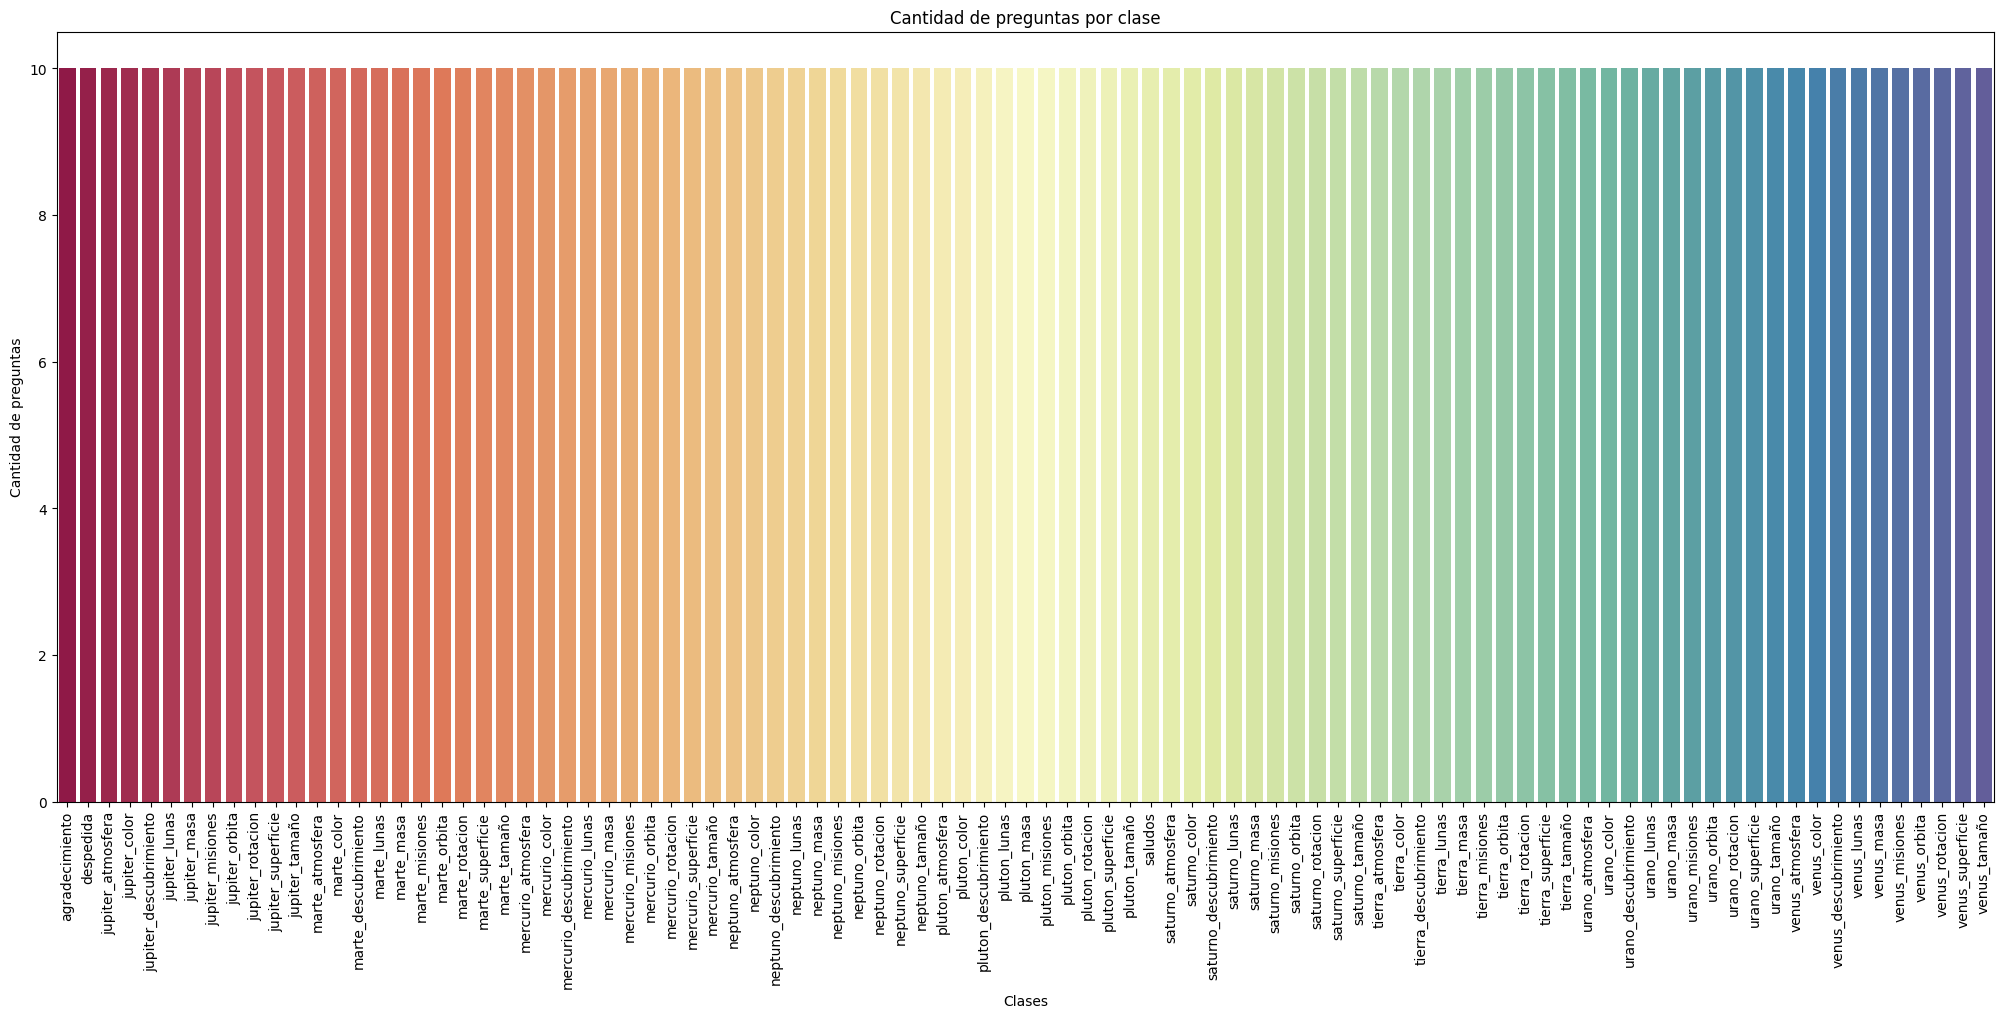

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

class_counts = df['label'].value_counts()
class_counts_sorted = class_counts.sort_index()

plt.figure(figsize=(25, 10))
ax = sns.barplot(x=class_counts_sorted.index, y=class_counts_sorted.values, palette='Spectral')
plt.title('Cantidad de preguntas por clase')
plt.xlabel('Clases')
plt.ylabel('Cantidad de preguntas')
# Rotar las etiquetas del eje x en 90 grados
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.show()

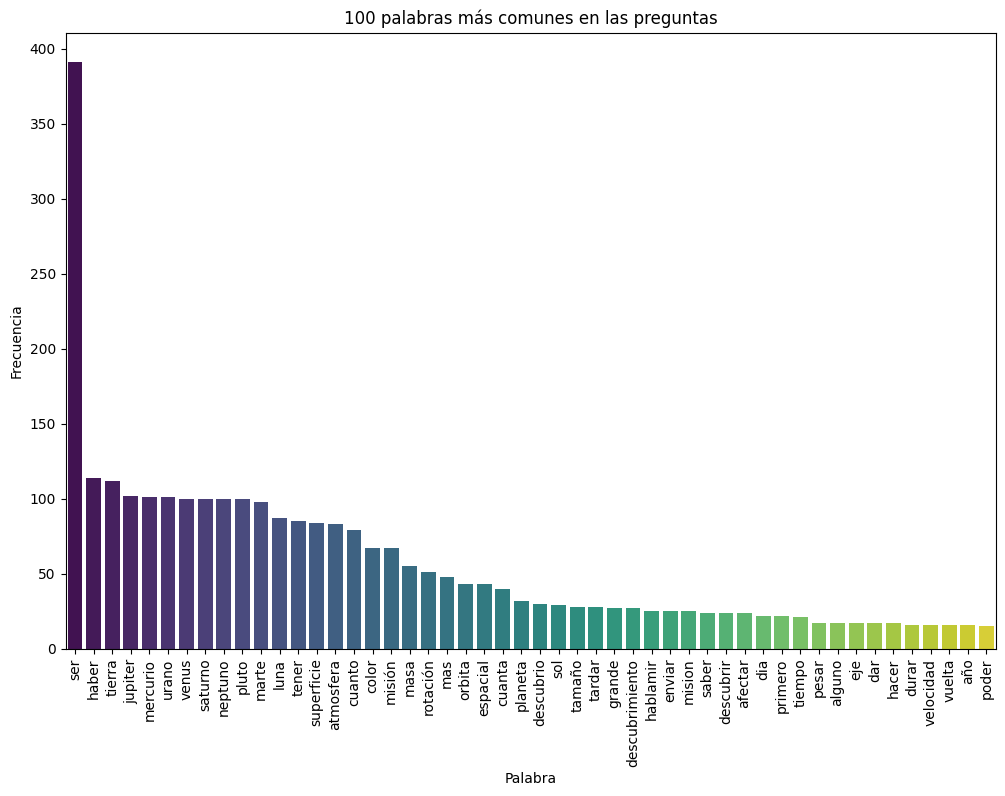

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

preguntas_words = ' '.join(df['pregunta_limpia'])
preguntas_words = preguntas_words.split()
word_freq_preguntas = Counter(preguntas_words)

# Obtener las 20 palabras más comunes y sus frecuencias
top_words = word_freq_preguntas.most_common(50)
top_words_df = pd.DataFrame(top_words, columns=['Palabra', 'Frecuencia'])

plt.figure(figsize=(12, 8))
sns.barplot(x='Palabra', y ='Frecuencia', data=top_words_df, palette='viridis')
plt.title('100 palabras más comunes en las preguntas')
plt.xlabel('Palabra')
plt.ylabel('Frecuencia')
# Rotar las etiquetas del eje x en 90 grados
plt.xticks(rotation=90)
plt.show()

Estadísticas descriptivas de la longitud de las preguntas:
count    930.000000
mean       4.169892
std        1.364298
min        1.000000
25%        3.000000
50%        4.000000
75%        5.000000
max       11.000000
Name: longitud_pregunta, dtype: float64
Estadísticas descriptivas de la longitud de las respuesta:
count    930.000000
mean      19.225806
std        9.258550
min        1.000000
25%       13.000000
50%       18.000000
75%       23.000000
max       69.000000
Name: longitud_respuesta, dtype: float64


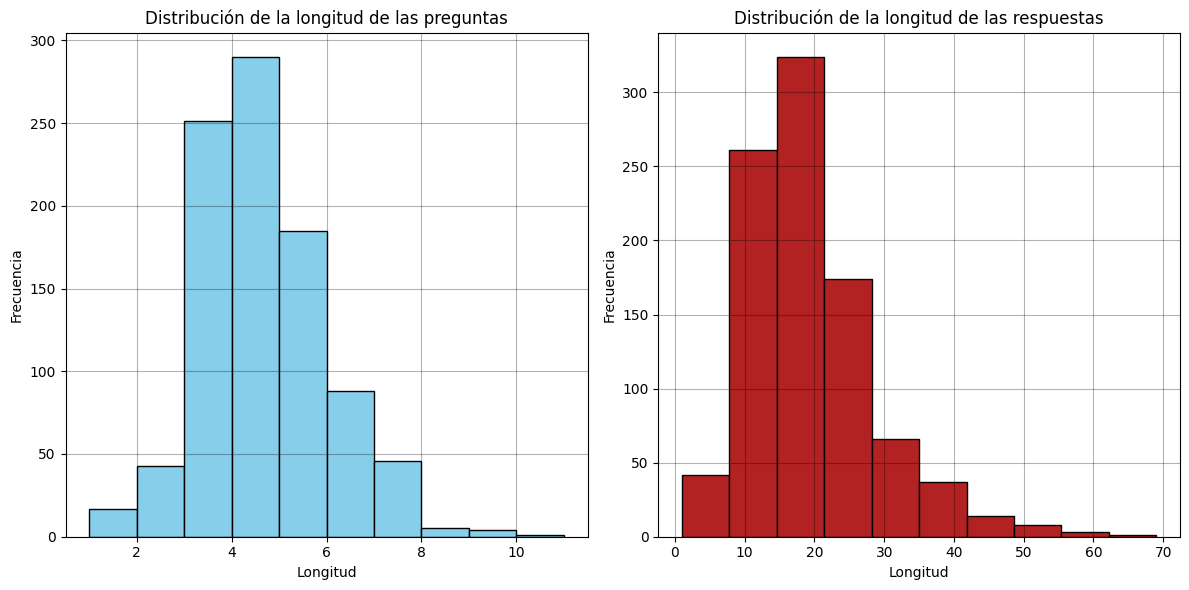

In [16]:
# Análisis de la longitud de las preguntas y respuestas
df['longitud_pregunta'] = df['pregunta_limpia'].apply(lambda x: len(x.split()))
df['longitud_respuesta'] = df['respuesta'].apply(lambda x: len(x.split()))

# Estadísticas descriptivas de la longitud de las preguntas
print("Estadísticas descriptivas de la longitud de las preguntas:")
print(df['longitud_pregunta'].describe())

# Estadísticas descriptivas de la longitud de las preguntas
print("Estadísticas descriptivas de la longitud de las respuesta:")
print(df['longitud_respuesta'].describe())

# Crear subplots para mostrar las distribuciones de ambas longitudes
fig, axs = plt.subplots(1, 2, figsize=(12, 6), facecolor='white')

# Histograma para la longitud de las preguntas
axs[0].hist(df['longitud_pregunta'], bins=10, color='skyblue', edgecolor='black' )
axs[0].set_title('Distribución de la longitud de las preguntas')
axs[0].set_xlabel('Longitud')
axs[0].set_ylabel('Frecuencia')
axs[0].grid(True, color='black', alpha=0.3)  # Cambiar el color del grid y establecer transparencia

# Histograma para la longitud de las respuestas
axs[1].hist(df['longitud_respuesta'], bins=10, color='firebrick', edgecolor='black')
axs[1].set_title('Distribución de la longitud de las respuestas')
axs[1].set_xlabel('Longitud')
axs[1].set_ylabel('Frecuencia')
axs[1].grid(True, color='black', alpha=0.3)  # Cambiar el color del grid y establecer transparencia

plt.tight_layout()
plt.show()


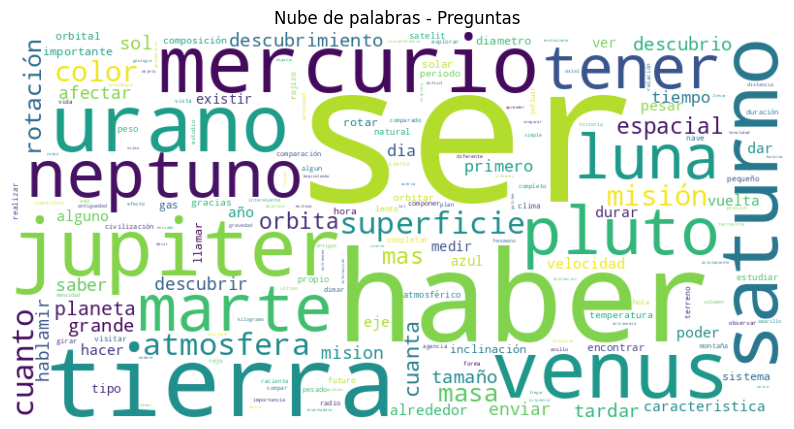

In [17]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter

preguntas_words = ' '.join(df['pregunta_limpia'])
preguntas_words = preguntas_words.split()
word_freq_preguntas = Counter(preguntas_words)

# Crear la nube de palabras
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq_preguntas)

plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Nube de palabras - Preguntas')
plt.show()

In [18]:
df.head()

,pregunta,respuesta,label,pregunta_minusculas,pregunta_sin_puntuacion,pregunta_corregida,pregunta_lematizada,pregunta_sin_stopwords,pregunta_limpia,longitud_pregunta,longitud_respuesta
0,Hola,¡Hola! ¿En qué puedo ayudarte?,saludos,hola,hola,hola,hola,hola,hola,1,5
1,¿Qué tal?,¡Hola! Estoy aquí para responder tus preguntas.,saludos,¿qué tal?,que tal,que tal,que tal,tal,tal,1,7
2,Buen día,¡Buen día! ¿En qué puedo ayudarte?,saludos,buen día,buen dia,buen dia,buen dia,buen dia,buen dia,2,6
3,Hola que tal ¿Cómo estás?,"Estoy bien, gracias. ¿En qué puedo ayudarte?",saludos,hola que tal ¿cómo estás?,hola que tal como estas,hola que tal como estas,hola que tal como este,hola tal,hola tal,2,7
4,Hola ¡Saludos!,¡Saludos! ¿Qué puedo hacer por ti?,saludos,hola ¡saludos!,hola saludos,hola saludos,hola saludos,hola saludos,hola saludos,2,6


In [19]:
# Crear un nuevo DataFrame con las columnas que quieres guardar
dfLimpio = df[['pregunta','pregunta_limpia', 'respuesta','label']]
# Guardar el DataFrame en un archivo CSV
dfLimpio.to_csv('datosChat.csv', index=False)  # El parámetro index=False evita guardar el índice del DataFrame en el archivo CSV


# **Cluster Kmeans**

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

# Vectorización de las preguntas utilizando TF-IDF
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(df['pregunta_limpia'])

# Aplicar K-Means para agrupar las preguntas en 5 clusters (puedes ajustar el número de clusters según tu preferencia)
num_clusters = 9
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(tfidf_matrix)

# Agregar las etiquetas de los clusters al DataFrame original
df['cluster'] = kmeans.labels_

# Mostrar ejemplos de preguntas en cada cluster
for cluster_num in range(num_clusters):
    cluster_questions = df[df['cluster'] == cluster_num]['pregunta'].head(5).tolist()
    print(f"\nCluster {cluster_num + 1}:")
    print(cluster_questions)



Cluster 1:
['¿Venus es más pequeño que Júpiter?', '¿Cuál es la masa de Júpiter?', '¿Cuánta masa tiene Júpiter?', '¿Cuál es la masa aproximada de Júpiter?', 'Dime, ¿cuánto pesa Júpiter?']

Cluster 2:
['Hola', 'Hola, ¿cómo te va?', 'Buen día', '¡Hola! ¿Qué tal estás hoy?', 'Hola ¡Saludos!']

Cluster 3:
['¿Cuál es la masa de Neptuno?', 'Masa de Neptuno', '¿Neptuno es más masivo que la Tierra?', '¿Qué tan grande es la masa de Neptuno?', 'Peso de Neptuno']

Cluster 4:
['¿Cuál es la masa de Mercurio?', '¿Qué tanto pesa Mercurio?', '¿Cuánto es la masa de Mercurio?', '¿Sabes cuál es el peso de Mercurio?', '¿Cuánta masa tiene Mercurio?']

Cluster 5:
['¿Cuál es la masa de Urano?', 'Háblame sobre la masa de Urano', '¿Qué tan pesado es Urano?', '¿Cuánta masa tiene Urano?', '¿Cómo se compara la masa de Urano con otros planetas?']

Cluster 6:
['¿Cuál es la masa de Plutón?', '¿Cuánto pesa Plutón?', '¿Cuánta masa tiene Plutón?', '¿Cuál es la masa total de Plutón?', '¿Qué tan pesado es Plutón?']

Clus

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [ ]:
# Suponiendo que 'label' contiene las etiquetas 'saludos' o 'agradecimientos'
filtro = df[(df['label'] == 'saludos') | (df['label'] == 'agradecimiento')]

# Seleccionar las columnas 'pregunta', 'cluster' y 'label'
resultados = filtro[['pregunta', 'cluster', 'label']]

# Mostrar los resultados
resultados.head(20)

,pregunta,cluster,label
0,Hola,1,saludos
1,"Hola, ¿cómo te va?",1,saludos
2,Buen día,1,saludos
3,¡Hola! ¿Qué tal estás hoy?,1,saludos
4,Hola ¡Saludos!,1,saludos
5,"Hola, alguien ahi!",1,saludos
6,"Hola, ¿qué tal?",1,saludos
7,Buenas tardes,1,saludos
8,"Hola, ¿cómo estás?",1,saludos
9,¡Buenos días!,1,saludos


In [ ]:
resultados = df[df['cluster'] == 0][['pregunta', 'cluster', 'label']]

In [ ]:
resultados['label'].unique()

array(['venus_tamaño', 'jupiter_masa', 'jupiter_tamaño', 'jupiter_lunas',
       'jupiter_atmosfera', 'jupiter_color', 'jupiter_rotacion',
       'jupiter_orbita', 'jupiter_superficie', 'jupiter_misiones',
       'jupiter_descubrimiento', 'neptuno_tamaño'], dtype=object)

In [ ]:
filtro = resultados[resultados['label'] == 'neptuno_tamaño']
texto_pregunta = filtro.iloc[0]['pregunta']
print(texto_pregunta)

¿Cómo se compara el tamaño de Neptuno con el de Júpiter?


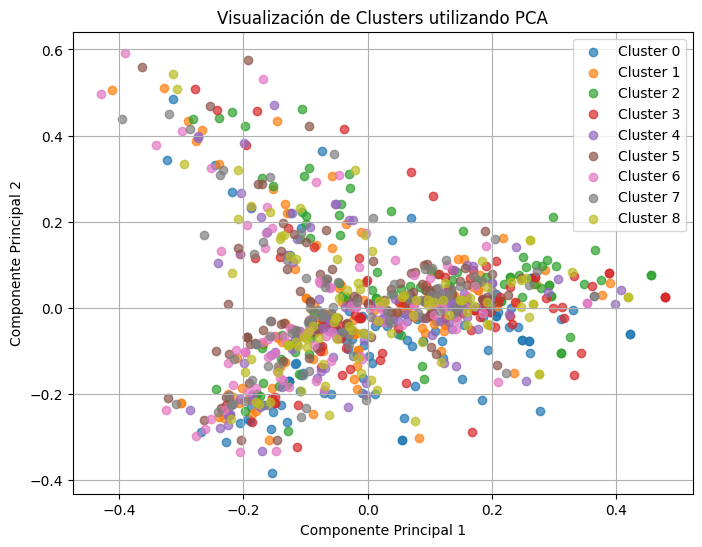

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

# Convertir matriz dispersa a una matriz densa (si es dispersa)
dense_tfidf_matrix = tfidf_matrix.toarray()  # Si es una matriz dispersa de SciPy
# dense_tfidf_matrix = tfidf_matrix.todense()  # Si es una matriz dispersa de numpy.matrix

# Reducción de dimensionalidad utilizando PCA a 2 componentes
pca = PCA(n_components=2)
tfidf_matrix_reduced = pca.fit_transform(dense_tfidf_matrix)  # Reducción de dimensionalidad

# Graficar los clusters utilizando PCA
plt.figure(figsize=(8, 6))
for cluster_num in range(num_clusters):
    plt.scatter(tfidf_matrix_reduced[df['cluster'] == cluster_num][:, 0],
                tfidf_matrix_reduced[df['cluster'] == cluster_num][:, 1],
                label=f'Cluster {cluster_num}',
                alpha=0.7)
plt.title('Visualización de Clusters utilizando PCA')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.legend()
plt.grid(True)
plt.show()


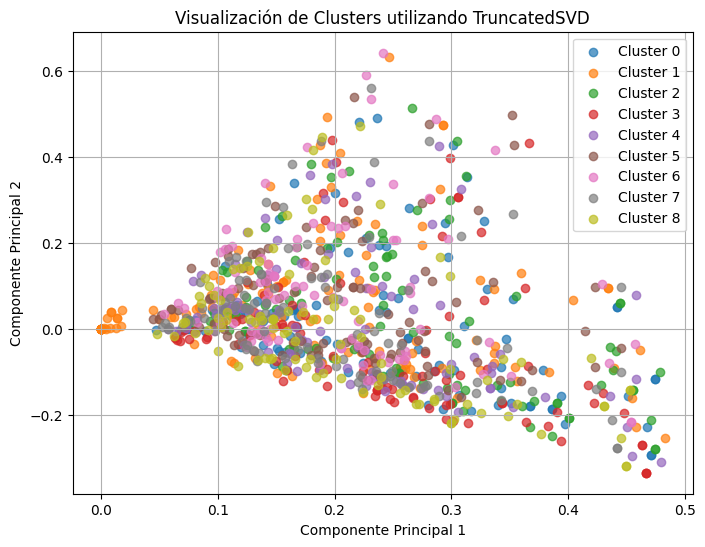

In [ ]:
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt

# Reducción de dimensionalidad utilizando TruncatedSVD a 2 componentes
svd = TruncatedSVD(n_components=2)
tfidf_matrix_reduced = svd.fit_transform(tfidf_matrix)

# Graficar los clusters utilizando TruncatedSVD
plt.figure(figsize=(8, 6))
for cluster_num in range(num_clusters):
    plt.scatter(tfidf_matrix_reduced[df['cluster'] == cluster_num][:, 0],
                tfidf_matrix_reduced[df['cluster'] == cluster_num][:, 1],
                label=f'Cluster {cluster_num}',
                alpha=0.7)
plt.title('Visualización de Clusters utilizando TruncatedSVD')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.legend()
plt.grid(True)
plt.show()


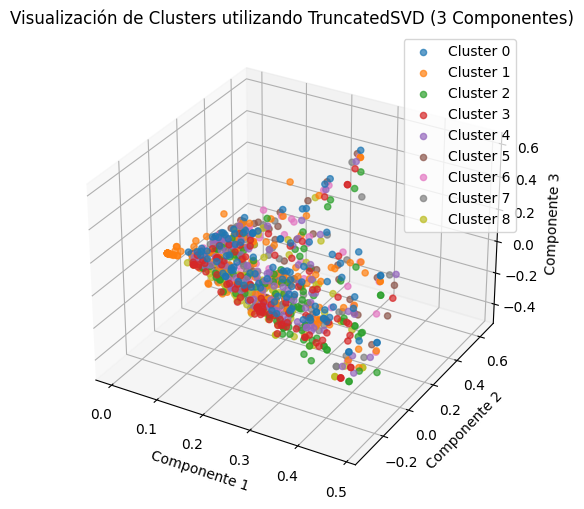

In [ ]:
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt

# Reducción de dimensionalidad utilizando TruncatedSVD a 3 componentes
svd = TruncatedSVD(n_components=3)
tfidf_matrix_reduced = svd.fit_transform(tfidf_matrix)

# Graficar los clusters utilizando TruncatedSVD
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

for cluster_num in range(num_clusters):
    ax.scatter(tfidf_matrix_reduced[df['cluster'] == cluster_num][:, 0],
               tfidf_matrix_reduced[df['cluster'] == cluster_num][:, 1],
               tfidf_matrix_reduced[df['cluster'] == cluster_num][:, 2],
               label=f'Cluster {cluster_num}',
               alpha=0.7)
ax.set_title('Visualización de Clusters utilizando TruncatedSVD (3 Componentes)')
ax.set_xlabel('Componente 1')
ax.set_ylabel('Componente 2')
ax.set_zlabel('Componente 3')
ax.legend()
plt.show()
